# Pytorch Work Flow
Fuentes:https://www.learnpytorch.io/, https://pytorch.org/tutorials/
https://pytorch.org/docs/stable/nn.html

In [70]:
import torch
from torch import nn  # Contiene todo lo necesario para crear redes neuronales
import matplotlib.pyplot as plt
import numpy as np

## 1. Datos (preparacion y carga)

Los datos pueden ser casi cualquier cosa.

En Machine Learning  hay dos partes principales:
1. Poner los datos como una representacion numerica
2. Construir un modelo para aprender los modelos en la representacion numerica

Para ejemplificar esto, podemos crear algunos datos *conocidos* usando la formula de la regresion linear.

Se usara la regresion lineal para crear una linea recta con **parametros** *conocidos* 

In [71]:
# Crear parametros conocidos
weight = 0.7  # Estos dos numeros pueden ser lo que queramos entre 1 y 0
bias = 0.3

# Creacion
inicio = 0
fin = 1
step = 0.02
x = torch.arange (inicio, fin, step).unsqueeze(dim = 1)
y = weight * x + bias #Esta seria la formula de la regresion lineal
x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [72]:
len(x), len(y)

(50, 50)

### Dividir los datos en sets de  entrenamiento y sets de pruebas

In [73]:
# Crear una separacion entrenamiento/pruebas
train_split = int(0.8 * len(x))
# Hay mejores maneras de realizar la division pero con un set de datos tan sencillo esto nos vale
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

len(x_train), len(y_train), len(x_test), len(y_test)

(40, 40, 10, 10)

Como podemos visualizar nuestos datos?

https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html

In [74]:
def plot_predictions(train_data=x_train,
                     train_labels=y_train,
                     test_data=x_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Da los datos de entrenamiento, los datos de las pruebas y compara las predcciones
  """
  plt.figure(figsize=(10, 7))

  # Presentar los datos de entrenamiento en azul
  plt.scatter(train_data, train_labels, c="b", s=4, label="Datos de entrenamiento")

  # Presentar los datos de las pruebas en rojo 
  plt.scatter(test_data, test_labels, c="r", s=4, label="Datos de pruebas")

  # Hay alguna predicccion?
  if predictions is not None:
    # Presentar las predicciones si es que existen
    plt.scatter(test_data, predictions, c="g", label="Predicciones")

  # Mostrar una leyenda
  plt.legend(prop={"size": 14})


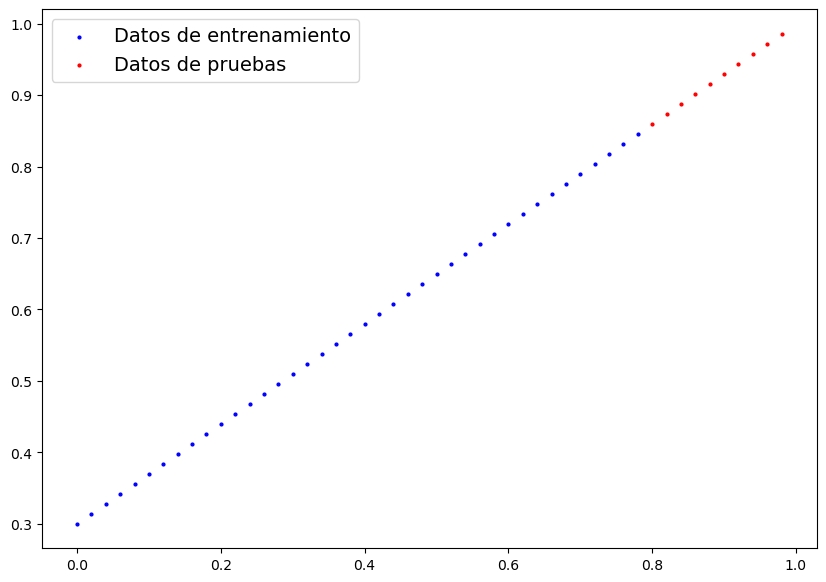

In [75]:
plot_predictions()

## 2. Construir un modelo

https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html
https://pytorch.org/docs/stable/generated/torch.nn.Module.html

Este modelo:
*  Empieza con valores aleatorios (weigths y bias)
*  Mira a los valores de entrenamiento para representar de mejor manera (o acercarse a) los valore ideales (el weight y bias que han sido utilizados para crear los datos)

Esto se hace principalmente mediante con dos algoritmos:
1. Descenso gradual  (Gradual descent)
2. "Backpropagation"

In [76]:
# Crear una clase modelo para la regresion lineal
class LinearRegressionModel(nn.Module): # Casi todo lo que se usara en Pytorch heredara de nn.module
  def __init__(self):
    super().__init__()

    # Se inicializan los parametros de nuestro modelo
    self.weights = nn.Parameter(torch.randn(1, out=None, dtype=torch.float, layout=torch.strided, device=None, requires_grad=True, pin_memory=False))
    self.bias = nn.Parameter(torch.randn(1, out=None, dtype=torch.float, layout=torch.strided, device=None, requires_grad=True, pin_memory=False))  
  
  # forward() define la computacion del modelo
  # cualquier subclase de nn.module necesitara sobreescribir el metodo forward()
  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.weights * x + self.bias # Formula de la regresion lineal

### Cosas esenciales para construir modelos en PyTorch

*  torch.nn => contiene todo lo necesario para crear graficos computacionales (una red neuronal es un grafico computacional)
*  torch.nn.Parameter => Los parametros que nuestro modelo deberia de probar y aprender, normalmente una de las capas torch.nn  hara esto por nosotros
*  torch.nn.Module => La clase base para todas las clases de redes neuronales. Si se usa se ha de sobreescribir el metodo forward()
*  torch.optim => Aqui es donde estan todos los optimizadores de PyTorch, estos ayudan con el descenso gradual

https://pytorch.org/tutorials/beginner/ptcheat.html

### Chequear el contenido de nuestro modelo

Podemos ver los parametros de nuestro modelo usando `.parameters`

In [77]:
torch.manual_seed(42)

# Crear una instancia del modelo

model_0 = LinearRegressionModel()

#list(model_0.parameters())
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [78]:
weight, bias

(0.7, 0.3)

### Hacer predicciones con torch.inference_mode()

Para ver el poder de prediccion de nuestro modelo, vamos a ver que tan bien puede predecir `y_test` basado e los datos de `x_test`.

Cuando pasamos datos a nuestro modelo los va a ejecutar a traves del metodo `fordward()`.

https://pytorch.org/docs/stable/generated/torch.inference_mode.html

In [79]:
with torch.inference_mode():
  y_preds = model_0(x_test)

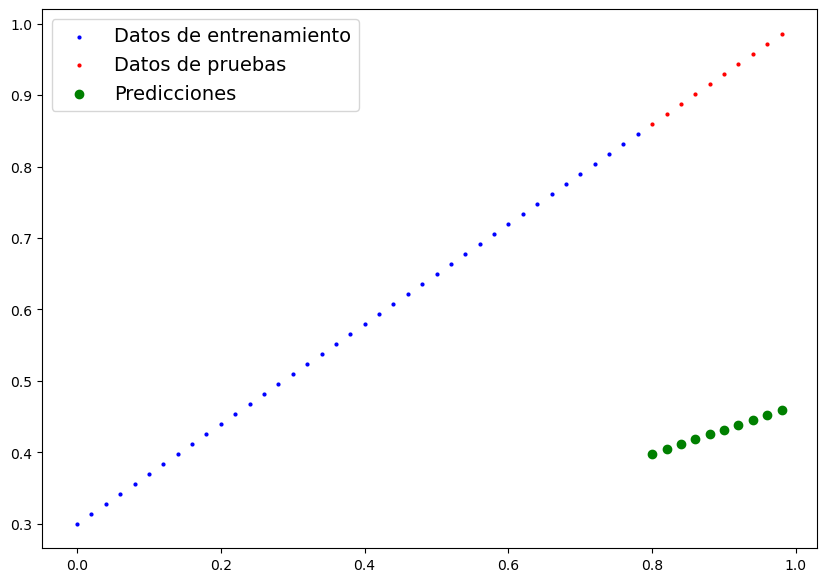

In [80]:
plot_predictions(predictions=y_preds)

## 3. Entrenar el modelo

La idea de entrenar un modelo es para pasar de unos parametros *desconocidos* (que podrian ser aleatorios) a unos parametros *conocidos*.

En otras palabras, de una representacion pobre de los datos a una mas certera.

Otra manera de medir que tan mal estan las predicciones de nuestro modelo es usar una "loss function".

Cosas que necesitamos para el entrenamiento:

*  **Loss functions:** Una funcion para medir que tan mal estan las preddiciones del modelo a los outputs ideales. Mientras menor, mejor.
*  **Optimizer:** Tiene en cuenta los errores del modelo y ajusta los parametros del modelo en consecuencia (en este caso weigh y bias).

Especificamente para PyTorch necesitamos:

*  Un loop de entrenamiento.
*  Un loop de pruebas

https://neptune.ai/blog/pytorch-loss-functions

https://pytorch.org/docs/stable/optim.html

https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

In [81]:
# Inizializar una "loss function"
loss_fn = nn.L1Loss()
# Esto es equivalente a hacer:
# loss_fn = torch.mean(torch.abs(y_pred - y_test))

# Inicializar un "optimizer" (En este caso se usa optim.SGD, siglas para "stochastic(aleatorio) gradiant descent")
optimizer = torch.optim.SGD(params = model_0.parameters(), lr = 0.01)  # lr son siglas para "learning rate". Se trata de uno de los hyperparametros mas importantes y detemina la posicion decimal en la que se va a hacer el cambio en nuestros parametros

 ### Construir el bucle de entrenamiento

 Cosas necesarias en los bucles de entrenamiento:
 1. Tener un loop a traves de nuestros datos.
 2. "Fordward pass", esto conlleva tener nuestros datos pasar a traves de el metodo `fordard()` para hacer las predicciones.
 3. Calcular la perdida comparando las predicciones con los datos.
 4. "Optimizer zero grad"
 5. "Loss backward", nos movemos marcha atras a traves de los datos para calcular los gradiantes de nuestros parametros con la perdida.  (**backpropagation**)
 6. "Optimizer step", usa el optimizer para ajustar los parametros de nuestro modelo minimizando la perdida. (**gradient descent**)

In [82]:
# Un epoch es un ciclo sobre nuestros datos
epochs = 200

# Llevar registro de los diferentes valores
epoch_count = []
loss_values = []
test_loss_values = []

# 1. Ciclar sobre el numero de epochs
for epoch in range(epochs):
  # Colocar el modelo en modo entrenamiento
  model_0.train() # El modo entrenamiento hace que todos los parametros que hemos marcado que necesitan gradiantes, requieran gradiantes.

  # 2. Fordward pass
  y_pred = model_0(x_train)

  # 3. Calcular la perdida
  loss = loss_fn(y_pred, y_train)
  #print(f"Loss:{loss}")

  # 4. Optimizer zero grad
  optimizer.zero_grad()

  # 5. Se realiza la backpropagation
  loss.backward() # Esto calcula los gradiantes de los parametros con respecto a la perdida

  # 6. Se avanza el optimizer (gradient descent)
  optimizer.step()  # De esta manera es se acumularan los cambios del optimizer a traves del ciclo. Es por esto que estos se ponen a cero en la siguiente iteracion del loop en el paso 3

  # Iniciar el modo de pruebas
  model_0.eval() # Deshabilita varias funciones del modelo que no son necesarias durante las pruebas

  with torch.inference_mode(): # Deshabilia el el seguimiento de gradiantes ya que en este momento no es necesario
    # 1.
    test_pred = model_0(x_test)

    #2.
    test_loss = loss_fn(test_pred, y_test)

  # Para ver lo que está pasando
  if epoch % 10 == 0:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)

    print(f"Epoch: {epoch} | Loss: {loss} | Test loss {test_loss}")
    print(model_0.state_dict())

Epoch: 0 | Loss: 0.31288138031959534 | Test loss 0.48106518387794495
OrderedDict([('weights', tensor([0.3406])), ('bias', tensor([0.1388]))])
Epoch: 10 | Loss: 0.1976713240146637 | Test loss 0.3463551998138428
OrderedDict([('weights', tensor([0.3796])), ('bias', tensor([0.2388]))])
Epoch: 20 | Loss: 0.08908725529909134 | Test loss 0.21729660034179688
OrderedDict([('weights', tensor([0.4184])), ('bias', tensor([0.3333]))])
Epoch: 30 | Loss: 0.053148526698350906 | Test loss 0.14464017748832703
OrderedDict([('weights', tensor([0.4512])), ('bias', tensor([0.3768]))])
Epoch: 40 | Loss: 0.04543796554207802 | Test loss 0.11360953003168106
OrderedDict([('weights', tensor([0.4748])), ('bias', tensor([0.3868]))])
Epoch: 50 | Loss: 0.04167863354086876 | Test loss 0.09919948130846024
OrderedDict([('weights', tensor([0.4938])), ('bias', tensor([0.3843]))])
Epoch: 60 | Loss: 0.03818932920694351 | Test loss 0.08886633068323135
OrderedDict([('weights', tensor([0.5116])), ('bias', tensor([0.3788]))])
E

In [83]:
with torch.inference_mode():
  y_preds_nuevo = model_0(x_test)

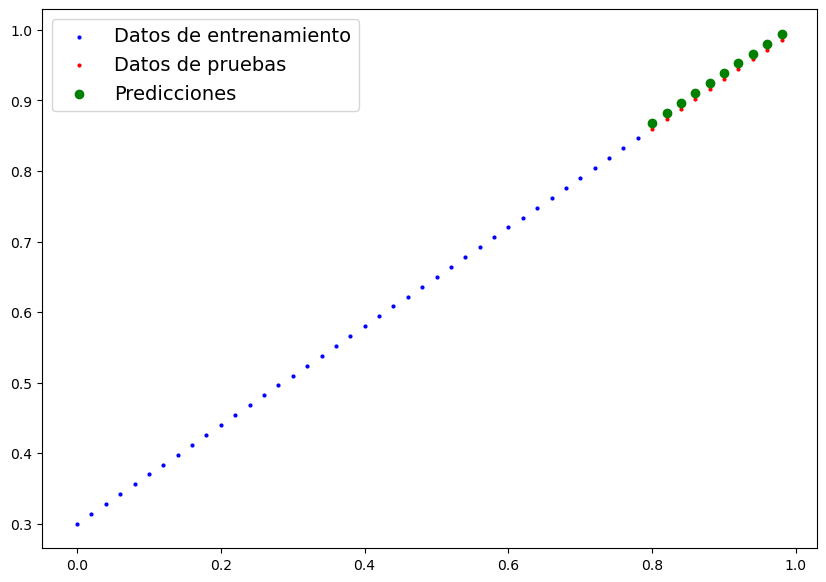

In [84]:
plot_predictions(predictions = y_preds_nuevo)

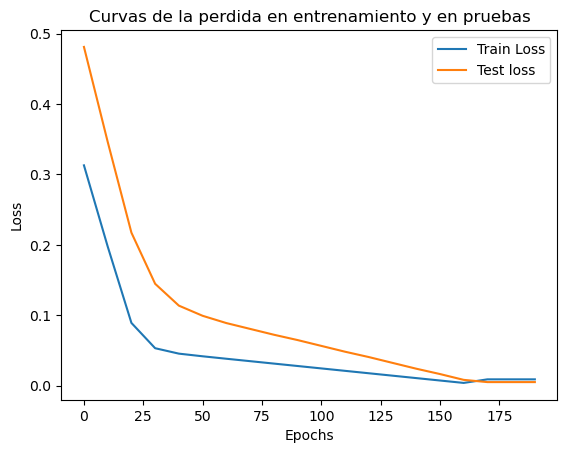

In [85]:
# Mostrar las curvas de loss
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label = "Train Loss") # Las listas han de contener valores de numpy para que esto funcione
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label = "Test loss")
plt.title("Curvas de la perdida en entrenamiento y en pruebas")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

## Guardar un modelo

Hay tres metodos principales para guardar y cargar los modelos en PyTorch.
1. `Torch.save()` => Te permite guardar un objeto de PyTorch en el formato pickle de python
2. `Torch.load()` => Te permite cargar un objeto de PyTorch
3. `Torch.nn.Module.load_state_dict()` => Te permite cargar el diccionario del estado de un modelo

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [86]:
from pathlib import Path

# Crear un directorio para el modelo
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True, exist_ok= True)

# Asignarle un nombre a el archivo de nuestro modelo
MODEL_NAME = "01_pytoch_workflow_model_0.pth"   # Los modelos de pytorch tendran la extension .pth
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Guardad nuestros modelos
torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

## Cargar un modelo de Pytorch

Como lo que se ha guardado ha sido el `state_dict()` de nuestro modelo, para cargarlo primero tenremos que crear una instancia de la clase y cargar el `state_dict()` en ella.

In [87]:
# Creamos una nueva instacia de la clase de nuestro modelo
model_0_loaded = LinearRegressionModel()

# Cargamos el state_dict() que habiamos guardado en el modelo nuevo
model_0_loaded.load_state_dict(torch.load(f = MODEL_SAVE_PATH))

# Comprobamos que los parametros son los mismos haciendo predicciones con el modelo cargado
model_0_loaded.eval()
with torch.inference_mode():
  loaded_model_preds = model_0_loaded(x_test)

loaded_model_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [88]:
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(x_test)

y_preds

tensor([[0.8685],
        [0.8825],
        [0.8965],
        [0.9105],
        [0.9245],
        [0.9384],
        [0.9524],
        [0.9664],
        [0.9804],
        [0.9944]])

In [89]:
# Comprobamos estas predicciones con las que habiamos hecho antes
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## Poniendolo todo junto

Vamos a ir algunos pasos atras y ponerlo todo en un solo sitio.

In [90]:
# importar pytorch y matplotlib
import torch
from torch import nn
import matplotlib.pyplot as plt

# Chequear la version de pytorch
print(f"Usando PyTorch version: {torch.__version__}")

Usando PyTorch version: 2.0.1


Crearemos codigo que tenga en cuenta los dispositivos disponibles.

Esto quiere decir que si tenemos una GPU, usaremos la GPU y si no, usaremos la CPU (Para una computacion más veloz).

In [91]:
# Inicializar el codigo para que tenga en cuenta los dispositivos disponibles
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando {device} device")

Usando cuda device


### Datos

In [92]:
# Crear unos datos utilizando la fórmula de la regresion lineal de: y = weight * x + bias
weight = 0.7
bias = 0.3

# Crer un rango de valores
inicio = 0
fin = 1
step = 0.02

# Crear x e y
x = torch.arange(inicio, fin, step).unsqueeze(dim = 1) # Unsqueeze añade una dimension extra a nuestros datos, sin esta dimension extra, el modelo no funcionaria
y = weight * x + bias
x[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

In [93]:
# Dividiremos los datos
division_de_entrenamiento = int(0.8 * len(x))
x_train, y_train = x[:division_de_entrenamiento], y[:division_de_entrenamiento] # 80% de los datos para entrenamiento
x_test, y_test = x[division_de_entrenamiento:], y[division_de_entrenamiento:] # 20% de los datos para pruebas

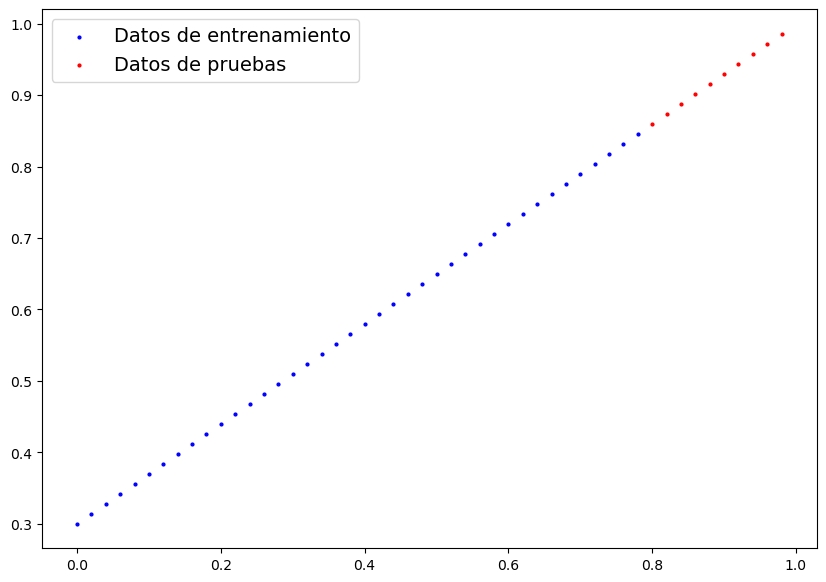

In [94]:
# Visualizar los datos
plot_predictions(train_data=x_train,
                 train_labels=y_train,
                 test_data=x_test,
                 test_labels=y_test)

### Crear el modelo linear de pytorch

https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [95]:
# Creamos un modelo lineal heredando de nn.Module
class ModeloDeRegresionLineal(nn.Module):
  def __init__(self):
    super().__init__()

    # Usamos nn.Linear para crear los parametros del modelo
    self.linear_layer = nn.Linear(in_features=1, out_features=1)

  def forward(self, x:torch.tensor) -> torch.tensor:
    return self.linear_layer(x)

torch.manual_seed(42)
model_1 = ModeloDeRegresionLineal()
model_1, model_1.state_dict()

(ModeloDeRegresionLineal(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

In [96]:
# Hacemos que nuestro modelo utilice el dispositivo que hemos elegido
model_1.to(device)
next(model_1.parameters()).device # Comprobamos que el dispositivo es el que hemos elegido

device(type='cuda', index=0)

### Entrenar el modelo
Para entrenar el modelo necesitamos:
* Una funcion de perdida
* Un optimizador
* Un loop de entrenamiento
* Un loop de pruebas

In [97]:
# inicializar la funcion de perdida
loss_fn = nn.L1Loss()

# Inicializar el optimizador
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [98]:
# Crear el loop de entrenamiento
torch.manual_seed(42)

epoch = 200

# Ponemos los datos en el dispositivo que hemos elegido
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

for epoch in range(epoch):
  model_1.train() # Colocar el modelo en modo entrenamiento

  # 1. Fordward pass
  y_pred = model_1(x_train)

  # 2. Calcular la perdida
  loss = loss_fn(y_pred, y_train)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Backpropagation
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval() # Colocar el modelo en modo pruebas
  with torch.inference_mode():
    test_pred = model_1(x_test)
    test_loss = loss_fn(test_pred, y_test)

  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")

Epoch: 0 | Loss: 0.5551779866218567 | Test loss: 0.5739762187004089
Epoch: 10 | Loss: 0.439968079328537 | Test loss: 0.4392664134502411
Epoch: 20 | Loss: 0.3247582018375397 | Test loss: 0.30455657839775085
Epoch: 30 | Loss: 0.20954833924770355 | Test loss: 0.16984669864177704
Epoch: 40 | Loss: 0.09433845430612564 | Test loss: 0.03513690456748009
Epoch: 50 | Loss: 0.023886388167738914 | Test loss: 0.04784907028079033
Epoch: 60 | Loss: 0.019956795498728752 | Test loss: 0.045803118497133255
Epoch: 70 | Loss: 0.016517987474799156 | Test loss: 0.037530567497015
Epoch: 80 | Loss: 0.013089174404740334 | Test loss: 0.02994490973651409
Epoch: 90 | Loss: 0.009653178043663502 | Test loss: 0.02167237363755703
Epoch: 100 | Loss: 0.006215683650225401 | Test loss: 0.014086711220443249
Epoch: 110 | Loss: 0.00278724217787385 | Test loss: 0.005814164876937866
Epoch: 120 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416882
Epoch: 130 | Loss: 0.0012645035749301314 | Test loss: 0.013801801018416

In [99]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [100]:
# Hacer predicciones con el modelo entrenado
model_1.eval()
#Hacemos predicciones con los datos de test
with torch.inference_mode():
  y_preds = model_1(x_test)

y_preds

tensor([[0.8600],
        [0.8739],
        [0.8878],
        [0.9018],
        [0.9157],
        [0.9296],
        [0.9436],
        [0.9575],
        [0.9714],
        [0.9854]], device='cuda:0')

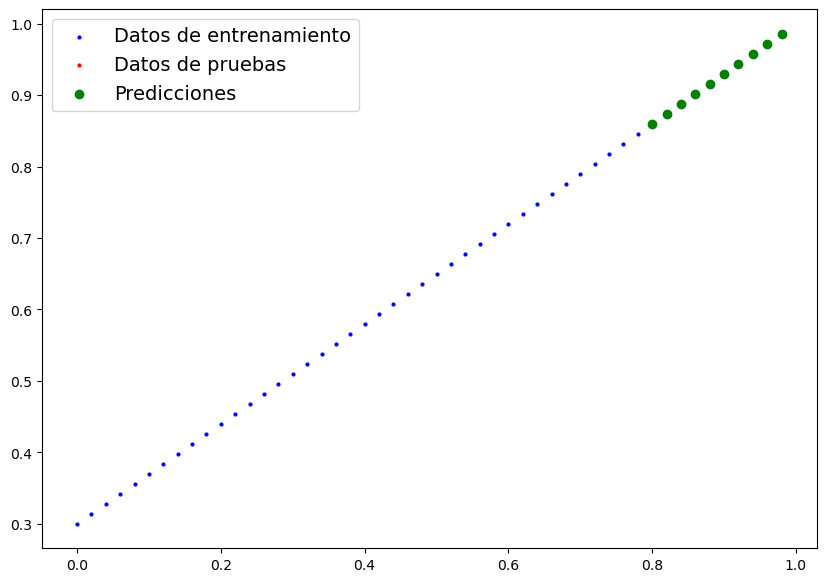

In [101]:
# Visualizar las predicciones
plot_predictions(predictions=y_preds.to("cpu"))

### Guardar y cargar un modelo

https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [102]:
from pathlib import Path

# Guardar el modelo

# Crear un directorio para el modelo
MODEL1_PATH = Path("models")
MODEL1_PATH.mkdir(parents=True, exist_ok=True)

# Asignarle un nombre a el archivo de nuestro modelo
MODEL1_NAME = "01_pytorch_workflow_model_1.pth"
MODEL1_SAVE_PATH = MODEL1_PATH / MODEL1_NAME

# Guardar nuestro modelo
torch.save(obj=model_1.state_dict(), f=MODEL1_SAVE_PATH)

In [103]:
# Cargar el modelo

# Crear una nueva instancia de la clase de nuestro modelo
model_1_loaded = ModeloDeRegresionLineal()

# Cargar el state_dict() que habiamos guardado en el modelo nuevo
model_1_loaded.load_state_dict(torch.load(f=MODEL1_SAVE_PATH))

# Ponemos el modelo cargado en el dispositivo que hemos elegido
model_1_loaded.to(device)

ModeloDeRegresionLineal(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [104]:
model_1_loaded.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [105]:
model_1_loaded.eval()
with torch.inference_mode():
  loaded_model_1_preds = model_1_loaded(x_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')

## Ejercicios y extra curriculares

https://www.learnpytorch.io/01_pytorch_workflow/#extra-curriculum